# Wavelet filtering 

author: steeve.laquitaine@epfl.ch

* 'han' threshold definition

### Setup

activate npx.. environment

In [2]:
# import libs
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import spikeinterface as si
from scipy.signal import detrend
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from scipy import signal
import spikeinterface.full as si
import spikeinterface.extractors as se 

# move to PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/"
os.chdir(PROJ_PATH)

from src.nodes.utils import get_config
from src.nodes.prepro.filtering import wavelet_filter

matplotlib.rcParams['agg.path.chunksize'] = 10000

# SETUP PARAMETERS

# - selected site
L5_SITE = 256  # site in layer 5

# - trace
SFREQ = 30000       # sampling frequency
nyquist = SFREQ / 2
DURATION_SECS = 1215 # secs

# - filtering
WAVELET = "haar"
NLEVEL = 6       # produces a high-pass filter cutoff of 234.375 Hz
THRESH_METHOD = "hard"

# - PSD plot
FILT_WIND_SIZE = 512500 #2300  # tuned to get a freq. resol. of 0.1 Hz
FILT_WIND_OVERLAP = int(FILT_WIND_SIZE // 1.5) #// 2 # overlap raises computational cost.
FILT_WINDOW = 'hann'

# butterworth filtering
FREQ_MIN = 234.375

# SETUP DATASET COMFIG
# vivo
data_conf_vivo, param_conf_h_vivo = get_config("vivo_marques", "c26").values()
RAW_PATH_vivo = data_conf_vivo["probe_wiring"]["output"]
PREP_PATH_vivo = data_conf_vivo["preprocessing"]["output"]["trace_file_path"]
SNR_PATH_vivo = data_conf_vivo["postprocessing"]["trace_snr"]
POWER_RAW_vivo = data_conf_vivo["analyses"]["traces"]["power"]["raw"]
POWER_PREP_vivo = data_conf_vivo["analyses"]["traces"]["power"]["preprocessed"]

2024-04-26 11:56:16,673 - root - utils.py - get_config - INFO - Reading experiment config.
2024-04-26 11:56:16,704 - root - utils.py - get_config - INFO - Reading experiment config. - done


### (2.5s) Load recordings

(27s) 36,450,000 samples (total duration of 1215 secs)

In [3]:
# load raw traces
RawVivo = si.load_extractor(RAW_PATH_vivo)

# get one "good" site in cortex
trace = RawVivo.get_traces(channel_ids=[L5_SITE], end_frame=SFREQ * DURATION_SECS)
trace = np.array(trace).flatten()
trace

array([43, 42, 46, ...,  1, -3, -4], dtype=int16)

### (2h) Wavelet denoising

#### Check high-pass filtering cutoff

In [11]:
nyquist = RawVivo.get_sampling_frequency() / 2
freq_cutoff = nyquist / 2**NLEVEL
print(freq_cutoff, "Hz")

234.375 Hz


#### Denoise

In [40]:
# all sites (2 sites)
denoised_traces = wavelet_filter(
    RawVivo,
    duration_s=DURATION_SECS,
    wavelet=WAVELET,
    method=THRESH_METHOD,
    nlevel=NLEVEL,
)
# # save filtered traces
PREPRO_PATH_WAVELET = "/gpfs/bbp.cscs.ch/project/proj85/laquitai/spikebias_paper/preprocessed/1_vivo/marques/campaign/c26_fixed/traces_wavelet"
# Preprocessed.save(folder=PREPRO_PATH_WAVELET, format="binary")

2024-04-26 10:58:33,514 - root - filtering.py - wavelet_filter_single_trace - INFO - high-pass filt. cutoff frequency: 234.375 Hz
2024-04-26 10:58:35,408 - root - filtering.py - wavelet_filter_single_trace - INFO - high-pass filt. cutoff frequency: 234.375 Hz


Exception ignored in: <function _releaseLock at 0x7fffe3d3e040>
Traceback (most recent call last):
  File "/gpfs/bbp.cscs.ch/home/laquitai/spack_install/environments/spack_python3_9/.spack-env/view/lib/python3.9/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


2024-04-26 10:58:39,650 - root - filtering.py - wavelet_filter_single_trace - INFO - number of samples used for decomposition: 36451520
2024-04-26 10:58:40,092 - root - filtering.py - wavelet_filter_single_trace - INFO - high-pass filt. cutoff frequency: 234.375 Hz
2024-04-26 10:58:43,230 - root - filtering.py - wavelet_filter_single_trace - INFO - number of samples used for decomposition: 36451520


### Butterworth filtering

In [36]:
# make a RecordingExtractor
trace_buttw = se.NumpyRecording(
    traces_list=[np.array([trace]).T],
    sampling_frequency=SFREQ,
)

# high-pass filter
butterworth_denoised = si.bandpass_filter(
    trace_buttw, freq_min=FREQ_MIN, freq_max=nyquist - 1
)

### (.6s) Plot

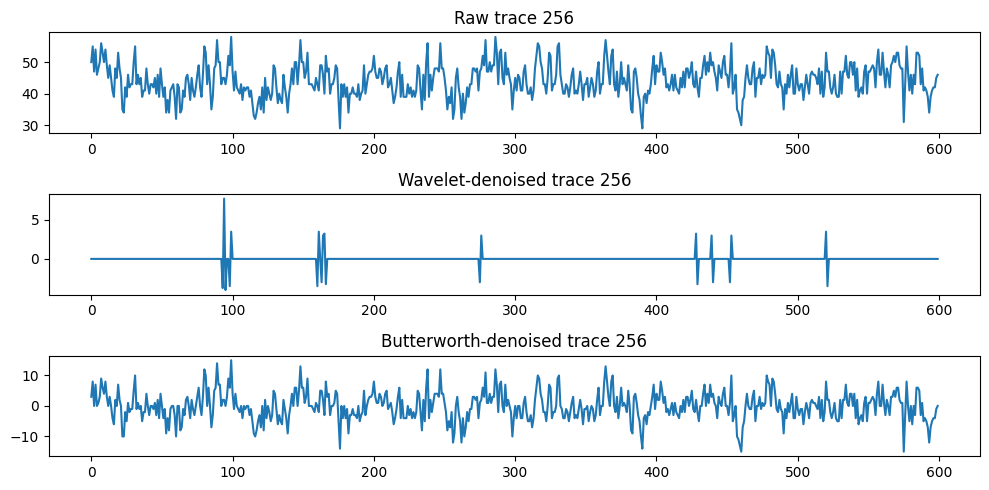

In [94]:
fig = plt.figure(figsize=(10, 5))

# raw
ax = fig.add_subplot(311)
ax.plot(trace[200:800])
ax.set_title(f"Raw trace {L5_SITE}")

# denoised
ax = fig.add_subplot(312)
ax.plot(denoised_traces[200:800, 0])
ax.set_title(f"Wavelet-denoised trace {L5_SITE}")

# denoised
ax = fig.add_subplot(313)
ax.plot(butterworth_denoised.get_traces()[200:800])
ax.set_title(f"Butterworth-denoised trace {L5_SITE}")

plt.tight_layout()

#### Zoom in 

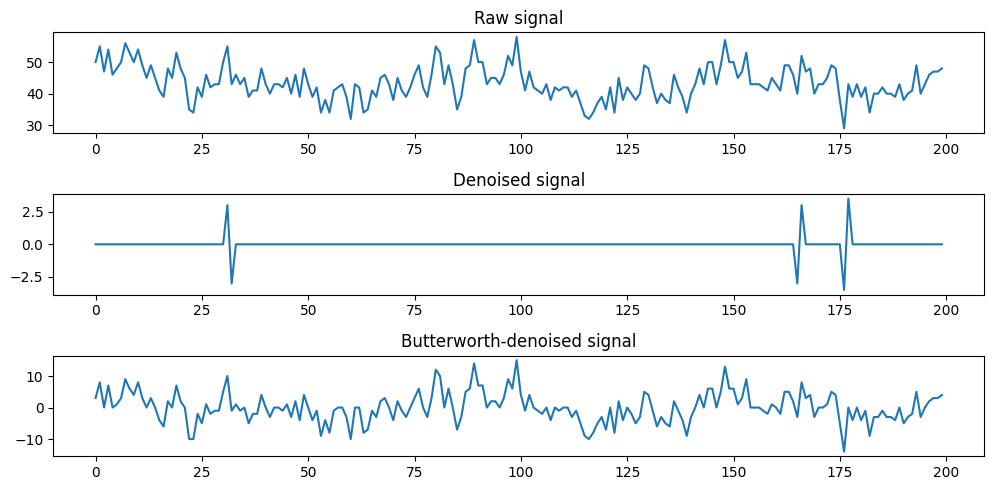

In [38]:
fig = plt.figure(figsize=(10, 5))

# raw
ax = fig.add_subplot(311)
ax.plot(trace[200:400])
ax.set_title(f"Raw trace {L5_SITE}")

# denoised
ax = fig.add_subplot(312)
ax.plot(denoised_traces[200:400, 0])
ax.set_title(f"Wavelet-denoised trace {L5_SITE}")

# denoised
ax = fig.add_subplot(313)
ax.plot(butterworth_denoised.get_traces()[200:400])
ax.set_title(f"Butterworth-denoised trace {L5_SITE}")

plt.tight_layout()

### (2.2s) Power spectral density

#### (5s) Check Welch's frequency resolution

In [18]:
# number of samples on which wavelet filtering can be applied
# with NLEVEL decompositions
size = (trace.shape[0] // 2**NLEVEL) * (2**NLEVEL)

# Welch method
freqs, powers = signal.welch(
    trace[:size],
    SFREQ,
    window=FILT_WINDOW,
    nperseg=FILT_WIND_SIZE,
    noverlap=FILT_WIND_OVERLAP,
)
print("Welch freq. resolution:", np.sort(freqs)[1] - np.sort(freqs)[0])
print("The upper bound freq. resolution (Fourier's):", SFREQ / trace.shape[0])

Welch freq. resolution: 0.05853658536585365
The upper bound freq. resolution (Fourier's): 0.0008230452674897119


#### (40s) Plot wavelet denoised PSD

#### Butterworth denoised PSD

# References

(1) https://github.com/steevelaquitaine/wavelet_denoise/blob/master/notebooks/wavelet_denoising.ipynb

(2) Wiltschko, Gage, and Berke, “Wavelet Filtering before Spike Detection Preserves Waveform Shape and Enhances Single-Unit Discrimination.” J Neurosci Methods (2008).

(3) Baldazzi et al., “Systematic Analysis of Wavelet Denoising Methods for Neural Signal Processing.”, Journal of Neural Engineering (2020)